# Analysis of models that predict ENSO well
- takes the models that show similar ENSO states following Krakatoa 
(an El Nino in DJF 1884 or 1885 AND a La Nina in DJF 1886)
- creates spatial plots of tas and pr for nino models, nina models and then all models

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import seaborn as sns
import dask.diagnostics # dask allows you to check how long something is taking to load

## Import and define custom functions

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
# define a function to take the ENSO models and take the time mean and multi-model mean
def ENSO_models(dataset, mods82, mods83, mods84, mods85):
    """Take the multi-model mean and DJF seasonal time mean for the four SH summers surrounding the eruption and combine the results for all four time periods in one xarray (output).
    
     Args:
        dataset (xarray): data set of anomalies to be used for further calculations
        mods82 (list): list of models that show a particular ENSO state in the first time period
        mods83 (list): list of models that show a particular ENSO state in the second time period
        mods84 (list): list of models that show a particular ENSO state in the third time period
        mods85 (list): list of models that show a particular ENSO state in the fourth time period
    """
    
    import xarray as xr 
    
    # select out the models for each time period and take the time mean and multi-model mean
    mean_mods82 = dataset.sel(model = mods82).sel(time=slice('1882-12','1883-02')).mean(dim=['model','time'])
    mean_mods83 = dataset.sel(model = mods83).sel(time=slice('1883-12','1884-02')).mean(dim=['model','time'])
    mean_mods84 = dataset.sel(model = mods84).sel(time=slice('1884-12','1885-02')).mean(dim=['model','time'])
    mean_mods85 = dataset.sel(model = mods85).sel(time=slice('1885-12','1886-02')).mean(dim=['model','time'])
    
    # combine models into one dataset 
    models_mean = xr.concat([mean_mods82, mean_mods83, mean_mods84, mean_mods85], dim='time', coords = 'minimal')
    models_mean.coords['time'] = ['1882', '1883', '1884', '1885']
    
    return models_mean

In [4]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


In [7]:
models_tas = funcM.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [8]:
models_pr = funcM.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [9]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [10]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 240, model: 44, time: 1980)
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * model    (model) <U17 'MPI-ESM-1-2-HAM' 'NESM3' ... 'SAM0-UNICON' 'IITM-ESM'
Data variables:
    tas      (model, time, lat, lon) float32 dask.array<chunksize=(1, 12, 120, 240), meta=np.ndarray>
    pr       (model, time, lat, lon) float64 dask.array<chunksize=(1, 12, 120, 240), meta=np.ndarray>

In [11]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


In [13]:
# area weighting 
models_w = models*np.cos(models.lat*(np.pi/180))

In [14]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
# e_pre3mon = ['1883-05','1902-7', '1962-12', '1982-01', '1991-03']
# e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']

## Anomalies 

In [15]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

In [16]:
# use functions to calculate the monthly anomalies for the globe and take the multi model mean 
K_mon_Glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')

In [17]:
# select out regions for other anomalies 
K_mon_SH = K_mon_Glob.sel(lat=slice(-90,0)) 
K_mon_NH = K_mon_Glob.sel(lat=slice(0,90)) 
K_mon_Aus = K_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
K_mon_EA = K_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

# select out models that get the enso state correct

In [18]:
func = reload(func)

In [19]:
# define nino models for each year
# 1882
models_nino82 = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-FV2', 
    'CESM2-WACCM', 'CanESM5', 'E3SM-1-1', 'FGOALS-f3-L', 'FGOALS-g3', 'GISS-E2-1-G-CC', 'KACE-1-0-G', 'MIROC6', 
    'SAM0-UNICON']
# 1883
models_nino83 = ['BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2-FV2', 'E3SM-1-1', 'EC-Earth3', 
    'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'GFDL-ESM4', 'IITM-ESM']
# 1884
models_nino84 = ['CESM2', 'CESM2-WACCM', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 
    'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IITM-ESM', 'KACE-1-0-G', 'NESM3', 
    'NorESM2-LM', 'SAM0-UNICON', 'TaiESM1']
# 1885
models_nino85 = ['ACCESS-ESM1-5', 'CAS-ESM2-0', 'CESM2-WACCM-FV2', 'CMCC-CM2-SR5', 
    'GISS-E2-1-G']

# store the number of nino models at each time in an array
count_nino_mods = [len(models_nino82), len(models_nino83), len(models_nino84), len(models_nino85)]

In [20]:
# define nina models for each year
#1882
models_nina82 = ['BCC-ESM1', 'CAS-ESM2-0', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3-AerChem', 
    'FIO-ESM-2-0', 'GFDL-CM4', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'MPI-ESM-1-2-HAM', 'NESM3', 
    'NorESM2-MM']
#1883
models_nina83 = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-ESM-1-1-LR', 'CMCC-CM2-SR5', 
    'EC-Earth3-AerChem', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'KACE-1-0-G','MRI-ESM2-0', 'NESM3', 
    'NorESM2-MM']
#1884
models_nina84 = ['ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAMS-CSM1-0', 
    'CESM2-WACCM-FV2', 'E3SM-1-1-ECA', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 
    'MPI-ESM1-2-LR', 'NorESM2-MM']
#1885
models_nina85 = ['CESM2', 'CMCC-CM2-HR4', 'E3SM-1-1', 'EC-Earth3-Veg-LR', 'FIO-ESM-2-0',
    'GFDL-CM4', 'GFDL-ESM4', 'IITM-ESM', 'KACE-1-0-G', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'NorCPM1', 
    'TaiESM1']

# store the number of nina models at each time in an array
count_nina_mods = [len(models_nina82), len(models_nina83), len(models_nina84), len(models_nina85)]

## I'm getting a total of 42 models instead of 43 so check which model is not included and add it to the neturals, or calculate neutrals differently 

In [21]:
# function to select out neutral models (ie those not in el nino or la nina arrays)
def other_models(models_all, models_nino, models_nina):
    """Select out neutral models (ie those not in el nino or la nina arrays). 
    
    Args:
        models_all (list): list of all models
        models_nino (list): list of all el nino models
        models_nina (list): list of all la nina models
    """
    other_models = models_all.where(~models_all.isin(models_nino + models_nina), drop = True)
    
    return other_models

In [22]:
# define the netural models for each year by selecting out the models that aren't in the el nino or la nina sets
models_neut82 = other_models(K_mon_Glob.model, models_nino82, models_nina82)
models_neut83 = other_models(K_mon_Glob.model, models_nino83, models_nina83)
models_neut84 = other_models(K_mon_Glob.model, models_nino84, models_nina84)
models_neut85 = other_models(K_mon_Glob.model, models_nino85, models_nina85)

# store the number of neutral models at each time in an array
count_neut_mods = [len(models_neut82), len(models_neut83), len(models_neut84), len(models_neut85)]

In [23]:
# this method misses the model INM-CM4-8 
# # define neutral models for each year
# # 1882
# models_neut821 = ['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CESM2', 'CESM2-WACCM-FV2', 'E3SM-1-1-ECA', 
#     'EC-Earth3', 'EC-Earth3-Veg-LR', 'GFDL-ESM4', 'GISS-E2-1-H', 'IITM-ESM', 'INM-CM5-0', 'MPI-ESM1-2-LR', 
#     'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'TaiESM1']
# #1883
# models_neut831 = ['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 
#     'CMCC-CM2-HR4', 'CanESM5', 'E3SM-1-1-ECA', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'INM-CM5-0', 
#     'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'NorCPM1', 'NorESM2-LM', 'SAM0-UNICON', 
#     'TaiESM1']
# #1884
# models_neut841 = ['ACCESS-CM2', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAS-ESM2-0', 'CESM2-FV2', 'CanESM5', 'E3SM-1-1', 
#     'EC-Earth3-AerChem', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MRI-ESM2-0', 'NorCPM1']
# #1885
# models_neut851 = ['ACCESS-CM2', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 
#     'CESM2-FV2', 'CESM2-WACCM', 'CanESM5', 'E3SM-1-1-ECA', 'EC-Earth3', 'EC-Earth3-AerChem', 'FGOALS-f3-L', 
#     'FGOALS-g3', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 
#     'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']

In [24]:
# select out the models that show nino/nina states and then take the DJF mean and mmm
nino_models_Glob = ENSO_models(K_mon_Glob, models_nino82, models_nino83, models_nino84, models_nino85)
nina_models_Glob = ENSO_models(K_mon_Glob, models_nina82, models_nina83, models_nina84, models_nina85)

nino_models_SH = ENSO_models(K_mon_SH, models_nino82, models_nino83, models_nino84, models_nino85)
nina_models_SH = ENSO_models(K_mon_SH, models_nina82, models_nina83, models_nina84, models_nina85)

nino_models_Aus = ENSO_models(K_mon_Aus, models_nino82, models_nino83, models_nino84, models_nino85)
nina_models_Aus = ENSO_models(K_mon_Aus, models_nina82, models_nina83, models_nina84, models_nina85)

nino_models_EA = ENSO_models(K_mon_EA, models_nino82, models_nino83, models_nino84, models_nino85)
nina_models_EA = ENSO_models(K_mon_EA, models_nina82, models_nina83, models_nina84, models_nina85)

In [25]:
# take DJF mean and mmm for neutral models 
neut_models_Glob = ENSO_models(K_mon_Glob, models_neut82, models_neut83, models_neut82, models_neut85)
neut_models_SH = ENSO_models(K_mon_SH, models_neut82, models_neut83, models_neut82, models_neut85)
neut_models_Aus = ENSO_models(K_mon_Aus, models_neut82, models_neut83, models_neut82, models_neut85)
neut_models_EA = ENSO_models(K_mon_EA, models_neut82, models_neut83, models_neut82, models_neut85)

In [26]:
# take DJF mean and mmm for all models 
# define an array of all the models 
models_all = K_mon_Glob.model
all_models_Glob = ENSO_models(K_mon_Glob, models_all, models_all, models_all, models_all)
all_models_SH = ENSO_models(K_mon_SH, models_all, models_all, models_all, models_all)
all_models_Aus = ENSO_models(K_mon_Aus, models_all, models_all, models_all, models_all)
all_models_EA = ENSO_models(K_mon_EA, models_all, models_all, models_all, models_all)

# figures 

In [27]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [28]:
# dates and title for eruption and 3 times after
K_dates = ['1882', '1883', '1884', '1885']
title_label = ['summer prior to eruption, ', '1st summer post-eruption, ', '2nd summer post-eruption, ', 
               '3rd summer post-eruption, ']

In [29]:
def ENSO_title(K_dates, title_label, count_mods=[43, 43, 43, 43]):
    """Create titles for graphs by combining strings for each year, summer post-eruption and number of models.  
    
    Args:
        K_dates (list): list of years to be plotted
        title_label (list): list of summer relative to eruption
        count_mods (list): number of models 
    """
        
    titles=[]
    for i,vals in enumerate(K_dates):
        t = title_label[i] + 'DJF ' + K_dates[i] + ', n=' + str(count_mods[i])
        titles.append(t)
    
    return titles

In [30]:
nino_titles = ENSO_title(K_dates, title_label, count_nino_mods)
nina_titles = ENSO_title(K_dates, title_label, count_nina_mods)
neut_titles = ENSO_title(K_dates, title_label, count_neut_mods)
all_titles = ENSO_title(K_dates, title_label)

In [31]:
# set the mod max for the colour bars
cmax_tas = 1
cmax_pr = 1

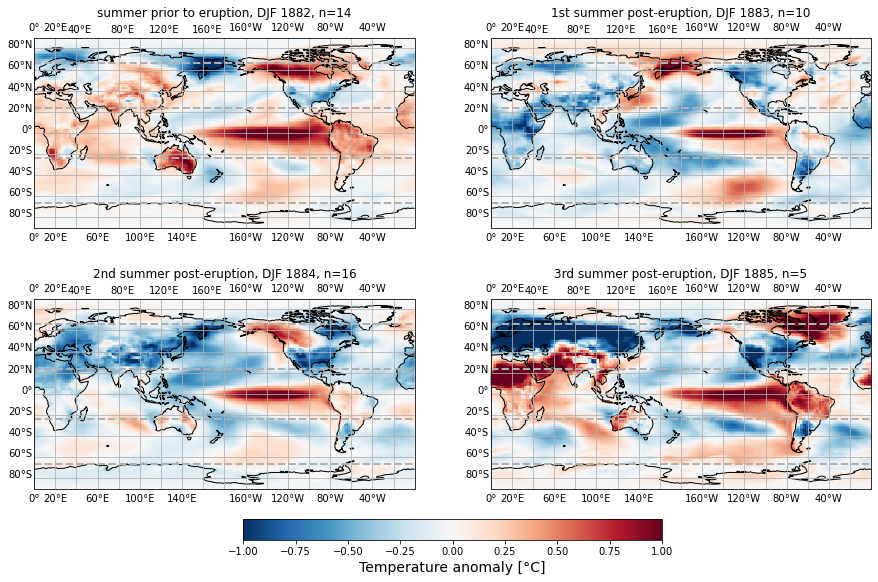

In [32]:
# plot of el nino models global monthly model mean temperature at 4 discrete time periods
fig = fplot.spatial_plot(2, 2, nino_models_Glob.tas, cmax_tas, K_dates, nino_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob_nino_mods.png', dpi=300, bbox_inches='tight')

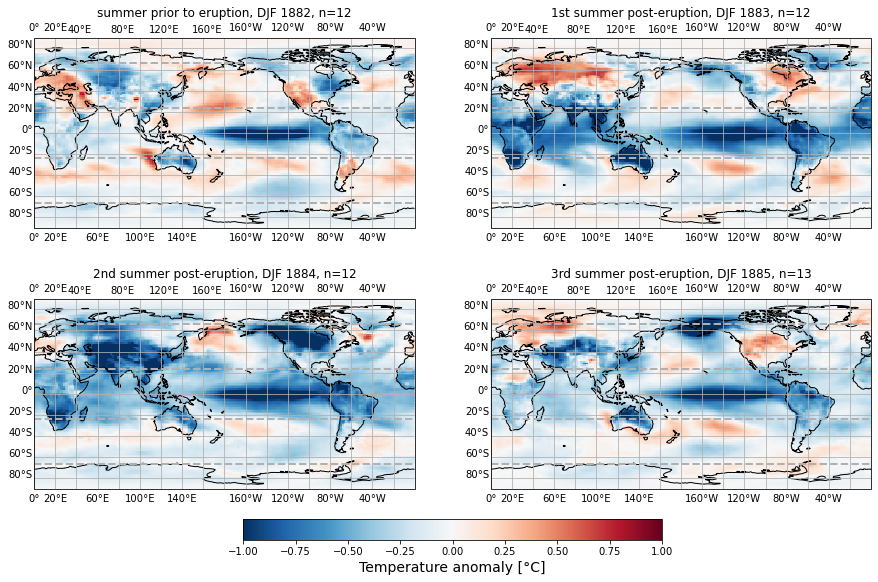

In [33]:
# plot of la nina models global monthly model mean temperature at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, nina_models_Glob.tas, cmax_tas, K_dates, nina_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob_nina_mods.png', dpi=300, bbox_inches='tight')

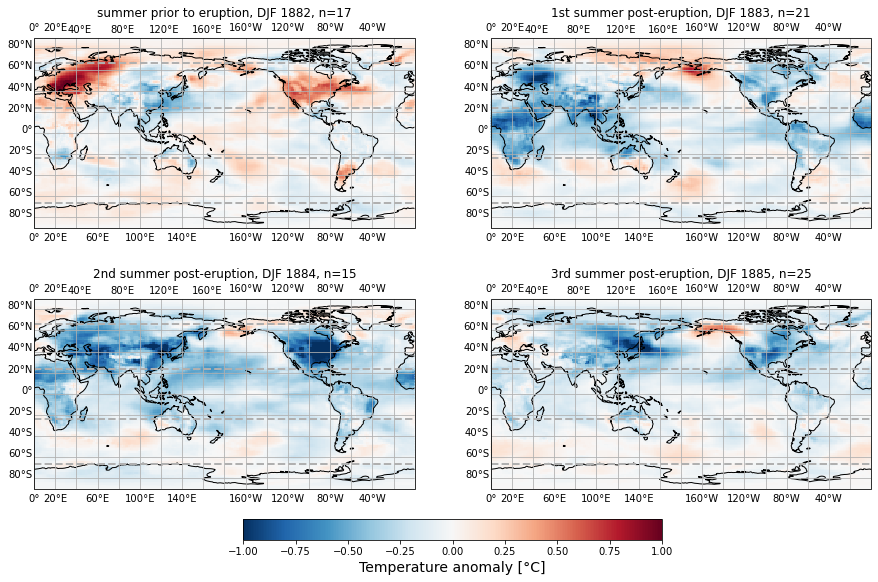

In [34]:
# plot of neutral models global monthly model mean temperature at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, neut_models_Glob.tas, cmax_tas, K_dates, neut_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob_neut_mods.png', dpi=300, bbox_inches='tight')

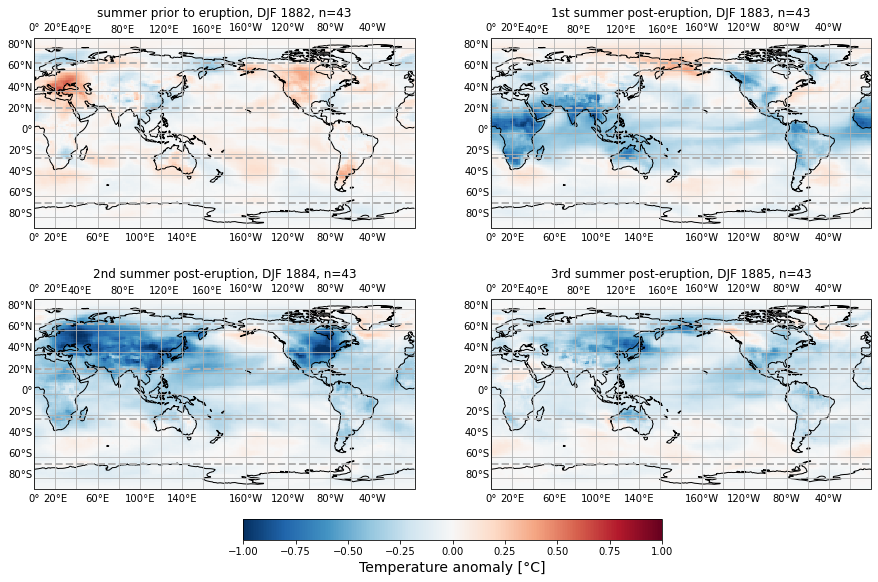

In [35]:
# plot of all models global monthly model mean temperature at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, all_models_Glob.tas, cmax_tas, K_dates, all_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob_all_mods.png', dpi=300, bbox_inches='tight')

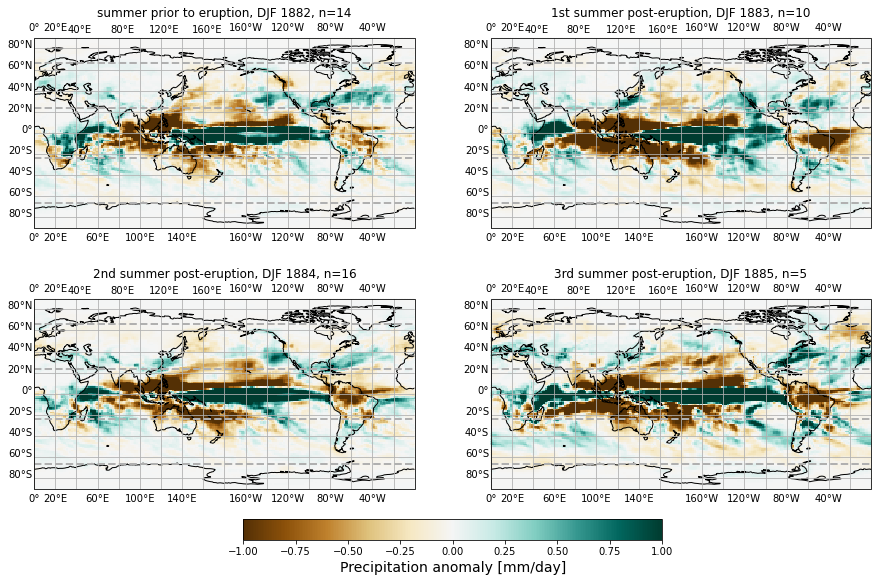

In [36]:
# plot of el nino models global monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, nino_models_Glob.pr, cmax_pr, K_dates, nino_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob_nino_mods.png', dpi=300, bbox_inches='tight')

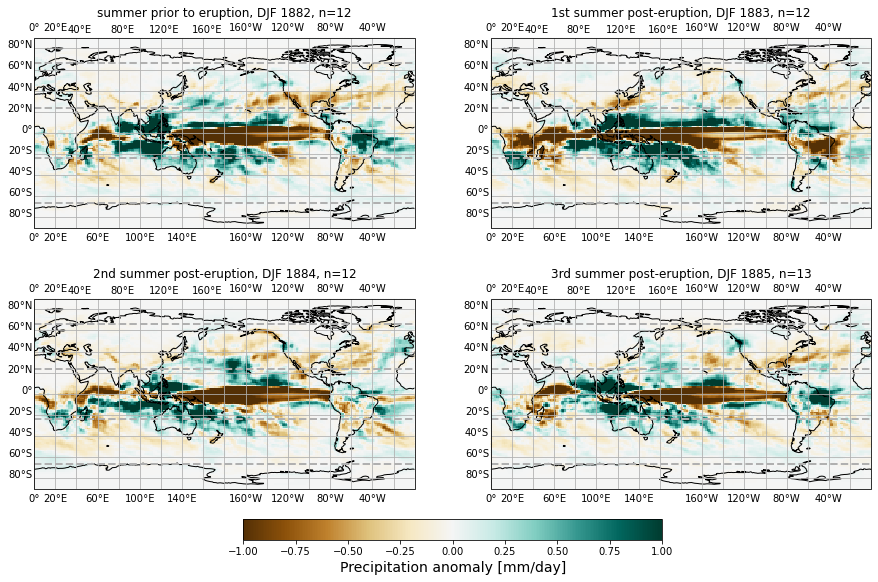

In [37]:
# plot of la nina models global monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, nina_models_Glob.pr, cmax_pr, K_dates, nina_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob_nina_mods.png', dpi=300, bbox_inches='tight')

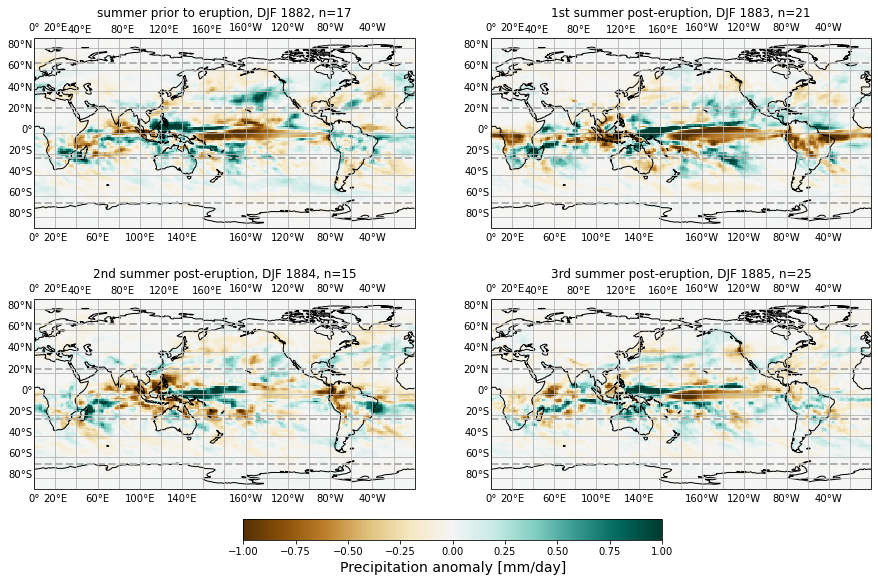

In [38]:
# plot of neutral models global monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, neut_models_Glob.pr, cmax_pr, K_dates, neut_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob_neut_mods.png', dpi=300, bbox_inches='tight')

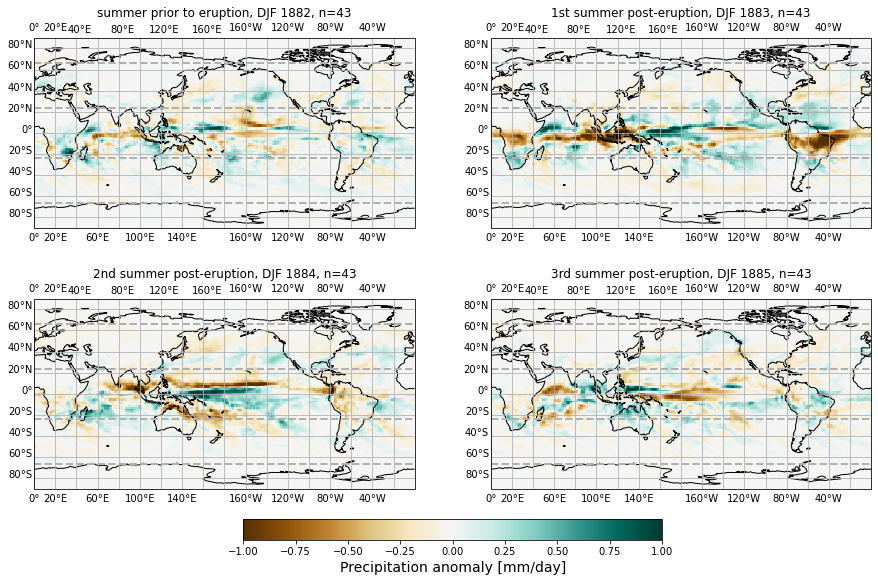

In [39]:
# plot of all models global monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, all_models_Glob.pr, cmax_pr, K_dates, all_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob_all_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


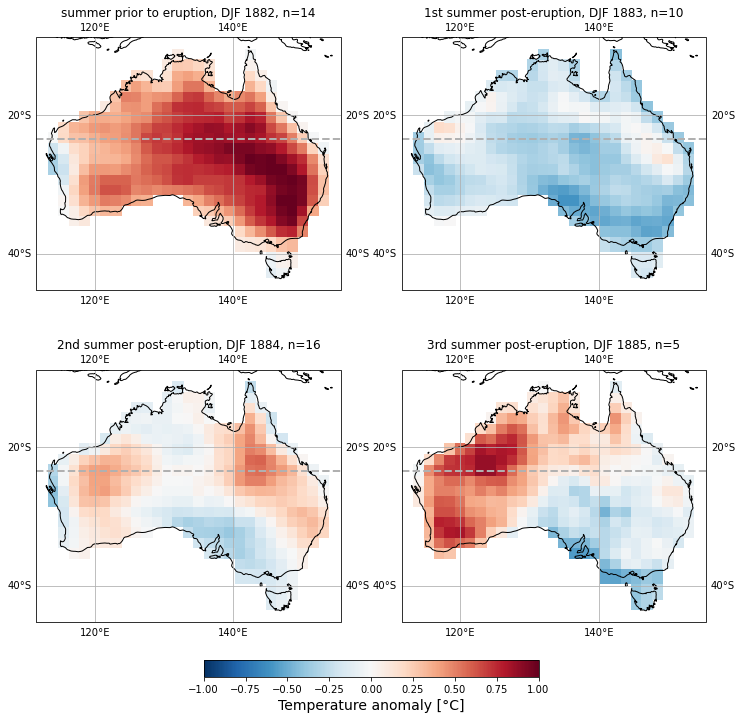

In [40]:
# plot of el nino models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, nino_models_Aus.tas, cmax_tas, K_dates, nino_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus_nino_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


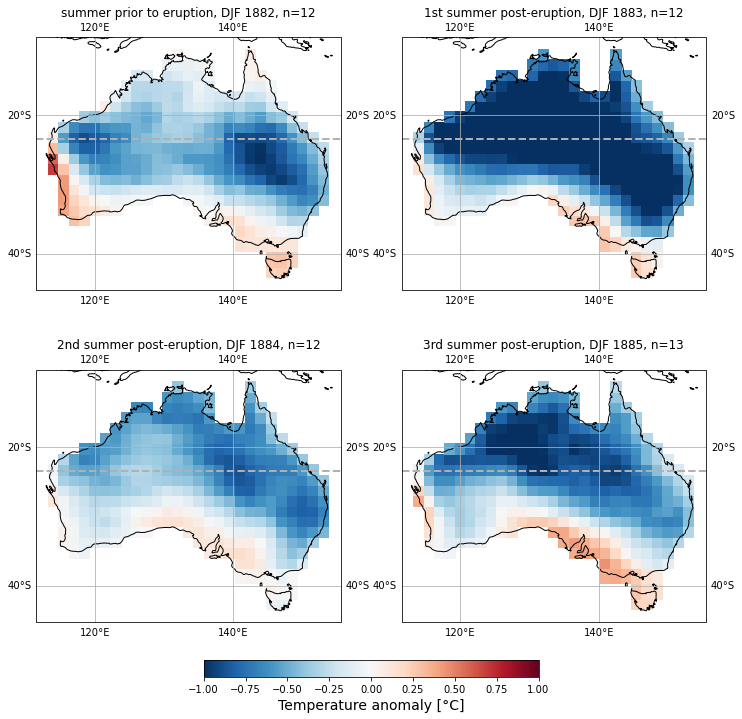

In [41]:
# plot of la nina models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, nina_models_Aus.tas, cmax_tas, K_dates, nina_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus_nina_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


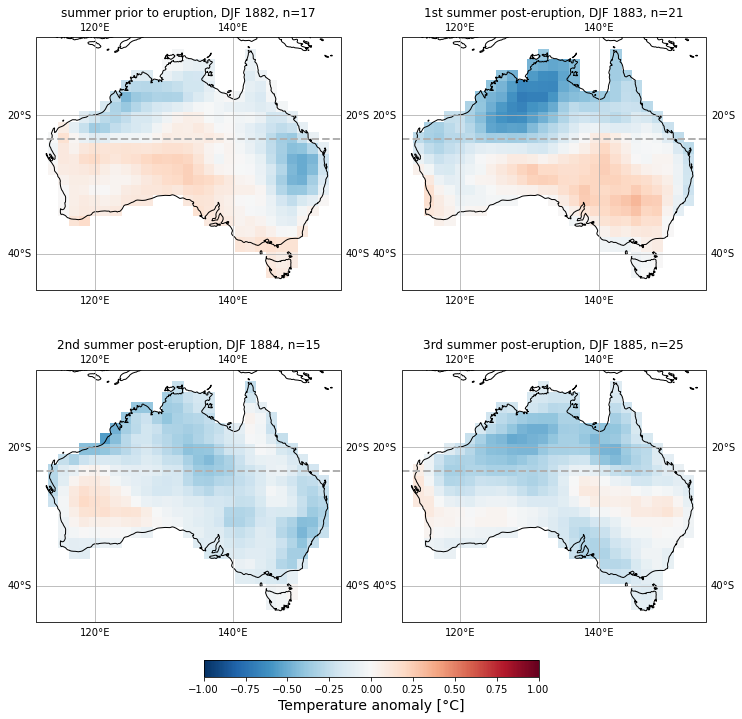

In [42]:
# plot of neutral models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, neut_models_Aus.tas, cmax_tas, K_dates, neut_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus_neut_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


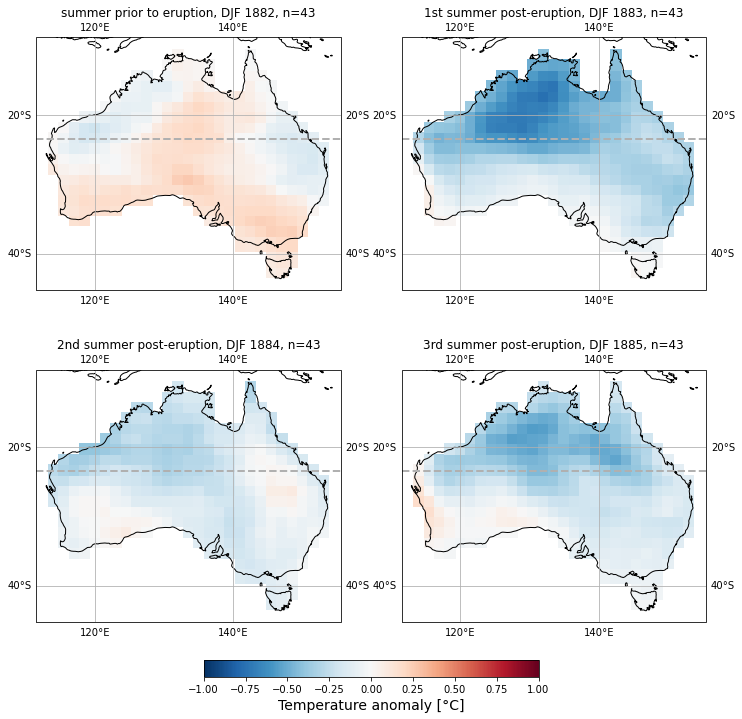

In [43]:
# plot of all models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, all_models_Aus.tas, cmax_tas, K_dates, all_titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus_all_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


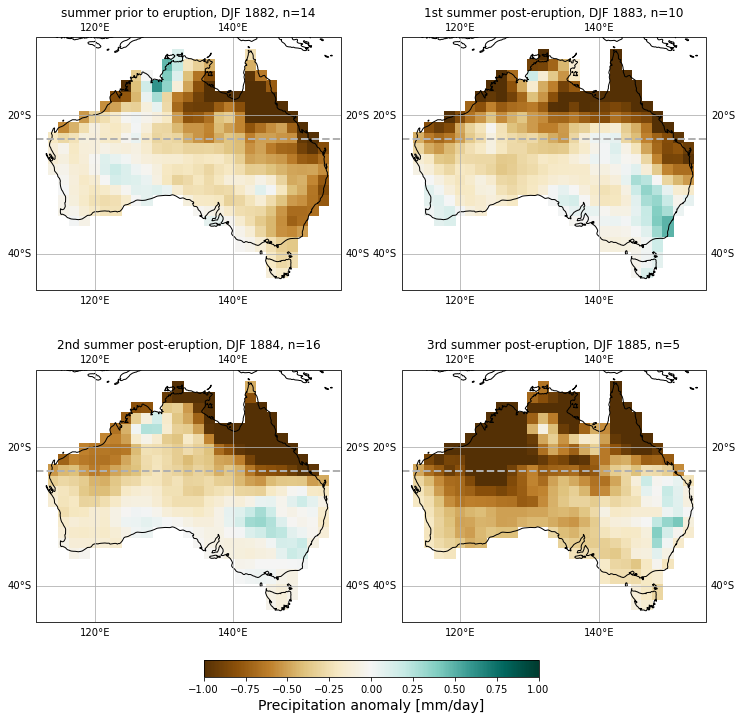

In [44]:
# plot of el nino models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, nino_models_Aus.pr, cmax_pr, K_dates, nino_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus_nino_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


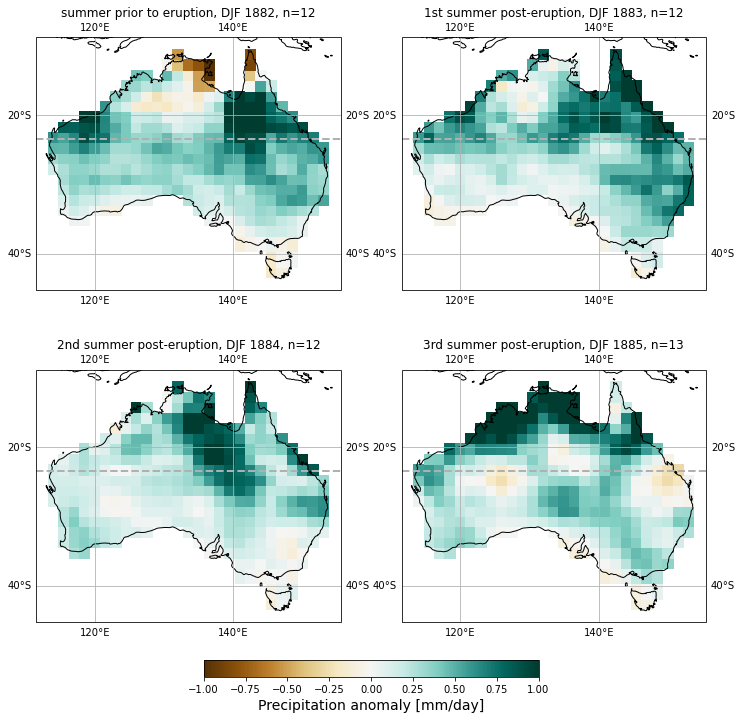

In [45]:
# plot of la nina models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, nina_models_Aus.pr, cmax_pr, K_dates, nina_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus_nina_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


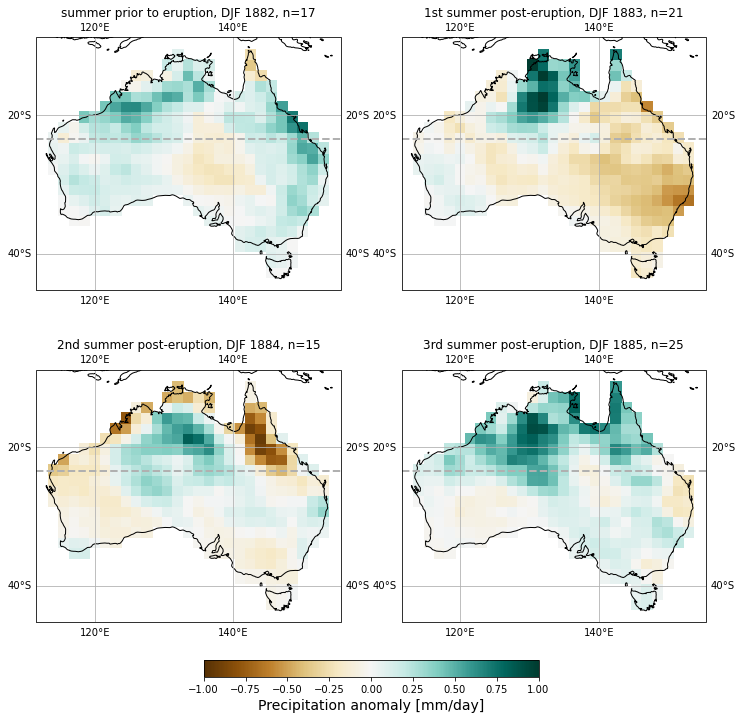

In [46]:
# plot of neutral models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, neut_models_Aus.pr, cmax_pr, K_dates, neut_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus_neut_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


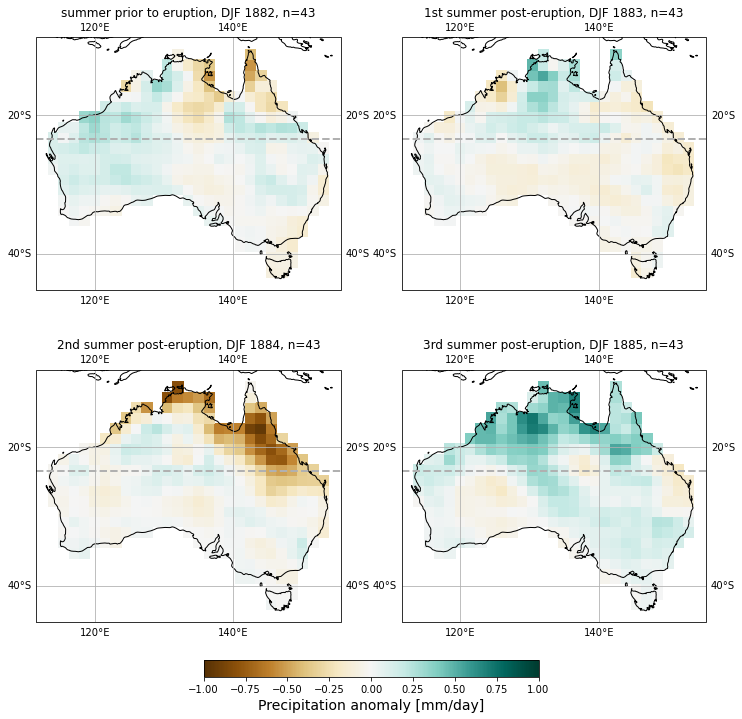

In [47]:
# plot of all models Australian monthly model mean rainfall at 4 discrete time periods 
fig = fplot.spatial_plot(2, 2, all_models_Aus.pr, cmax_pr, K_dates, all_titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus_all_mods.png', dpi=300, bbox_inches='tight')